### 7.1 전체구조

합성곱 신경망(convolutional neural network, CNN)  
(합성곱 : 컨볼루션. 두 함수 중 하나를 반전, 이동시켜가며 나머지 함수와의 곱을 연이어 적분하는 것)  
지금까지 본 신경망은 인접하는 계층의 모든 뉴런과 결합되어 있었다. 이를 완전연결fully-connected라고 하며,  
이를 Affine 계층이라는 이름으로 구현했다.
CNN에는 여기에 합성곱 계층과 풀링 계층이 추가된다. 
Affine-ReLu가 Conv-ReLU-(Pooling)으로 바뀌며 출력에 가까운 층에서는 Affine-ReLU 구성을 
사용할 수 있다. 출력 계층에서는 Affine-Softmax 조합을 사용한다.
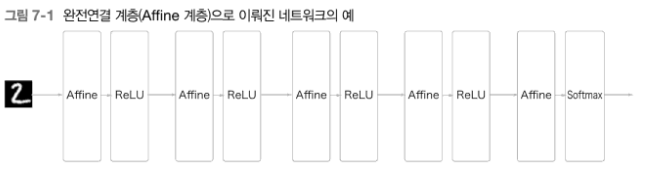
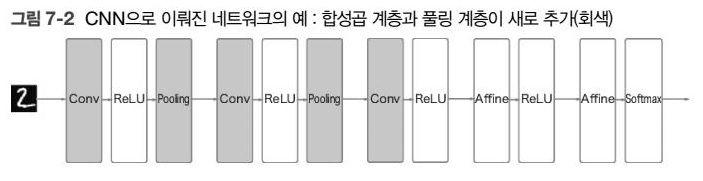

## 7.2 합성곱 계층
### 7.2.1 완전연결 계층의 문제점

완전연결Affine 계층 : 인접하는 계층의 뉴런이 모두 연결되고 출력의 수는 임의로 정할 수 있다.  
단점은 데이터의 형상이 무시된다.(가로, 세로, 채널로 구성된 3차원 데이터인 이미지를 1차원 데이터로 평탄화해줘야 한다.)  
합성곱 계층은 형상을 유지하기 때문에 형상을 가진 데이터의 패턴을 이해할 수 있다.  
CNN에서는 입출력 데이터를 특징 맵feature map이라고도 한다.  


### 7.2.2 합성곱 연산

완전연결 신경망에는 가중치 매개변수와 편향이 존재하는데, CNN에서는 필터의 매개변수가 그동안의 '가중치'에 해당한다!
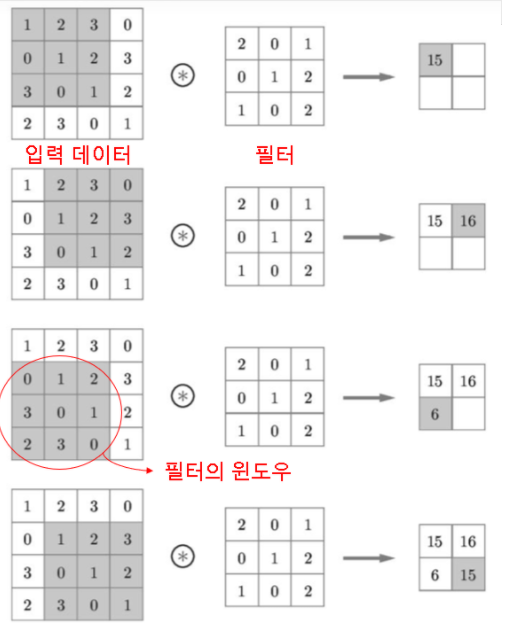

### 7.2.3 패딩

패딩 : 합성곱을 수행 전 입력 데이터 주변을 특정 값(0 등)으로 채우는 것.  
주로 출력 크기 조정을 목적으로 사용한다. 출력 크기가 커지기 때문에 입력 데이터의 공간적 크기를  
유지한 채로 다음 계층에 전달할 수 있다.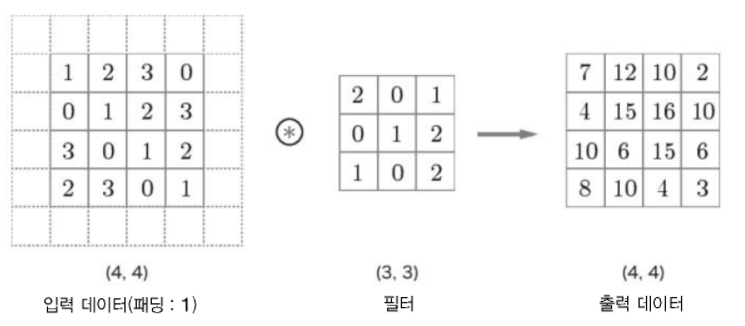

- 위 입력데이터가 4,4 인데 출력데이터를 4,4로 만들어주려고 입력데이터 주변을 특정 값으로 채웠다! = 패딩

### 7.2.4 스트라이드

스트라이드stride : 필터를 적용하는 위치의 간격. 일반적으로는 1이지만
2로 하면 필터를 적용하는 윈도우가 두 칸씩 이동한다. 스트라이드를 키우면 출력 크기가 작아진다.
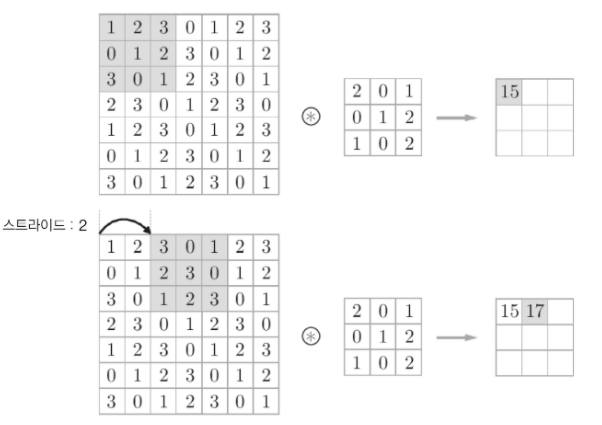

- 위처럼 지금까지 본 예는 모두 스트라이드가 1이었지만, 스트라이드를 2로 하면 필터를 적용하는 윈도우가 두 칸씩 이동한다.

### 7.3 풀링계층
풀링 : 가로 세로 방향의 공간을 줄이는 연산. 여러 영역을 원소 하나로 집약하여 공간 크기를 줄인다.

### 7.4 합성곱/풀링 계층 구현하기
### 7.4.1 4차원 배열
CNN의 데이터는 4차원이다.

In [3]:
import numpy as np
x = np.random.rand(10, 1, 28, 28)  # 무작위 데이터 생성
print(x.shape)

# 첫 번째 데이터, 두 번째 데이터
print(x[0].shape)  # (1, 28, 28)
print(x[1].shape)  # (1, 28, 28)

(10, 1, 28, 28)
(1, 28, 28)
(1, 28, 28)


### 7.4.3 합성곱 계층 구현하기

In [4]:
'''
인터페이스는 다음과 같다.
im2col(input_data, filter_h, filter_w, stride=1, pad=0)
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    '''

'\n인터페이스는 다음과 같다.\nim2col(input_data, filter_h, filter_w, stride=1, pad=0)\n    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)\n    filter_h : 필터의 높이\n    filter_w : 필터의 너비\n    stride : 스트라이드\n    pad : 패딩\n    '

im2col(input_data, filter_h, filter_w, stride=1, pad=0)


In [8]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h) / stride + 1
    out_w = (W + 2*pad - filter_w) / stride + 1

    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [11]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 전개
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        # 최댓값 axis : 축의 방향, 0=열방향, 1=행방향
        out = np.max(col, axis=1)

        # 성형
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out
